### Stan
Using the statistical modelling software stan (here its Python interface Pystan) to use the PMCMC algorithm to solve the SARS-CoV-2 model. 

In [1]:
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('utils')
from utils.model import *

sns.set()  # Nice plot aesthetic
np.random.seed(101)

#### Define the model in stan
Structure:

1. functions:  external functions needed (here: differential equation)
2. data:                    all the data including observations, time and known parameters
3. tranformed data:         if the data still needs to be transformed
4. parameters:              the parameters (which need to be estimated)
5. transformed parameters:  potential transformation of the parameters (here: solve the differential equation)
6. model:                   define the probability distributions that define your model
7. generated quantities:    in case any other parameters might be needed to be computed

In [2]:
# older model:
model = """functions {
  real[] SEIR(
      real t,             // time
      matrix[] Z,           // system state {susceptible, exposed, infected, recovered}
      real[] theta,       // parameters (t_inc, t_inf, r_t, mu, t_rec, rho = 1, kappa_0, kappa)
      real[] X_r,         // --------probably not needed
      int[] X_i) {        // --------probably not needed
  
          real dZ_dt[4];
          
          real t_inc   = theta[1];
          real t_inf   = theta[2];
          real r_t     = theta[3];
          real rho     = theta[4];
          real kappa_0 = theta[5];
          real kappa   = theta[6];
         
          dZ_dt[1] = - rho * (r_t/t_inf) * Z[1] * Z[2]  - kappa_0 * Z[1] ;     
          dZ_dt[2] = (rho * (r_t/t_inf) * Z[1] * Z[2])    -     ((1/t_inc) * Z[2]) - kappa_0 * Z[3] - kappa * Z[3]  ;    
          dZ_dt[3] = ((1/t_inc) * Z[2]) -   (1/t_inf) * Z[3];
          dZ_dt[4] = (1/t_inf) * Z[3];
          
          return dZ_dt;
      }
      real[ , ] integrate_SEIR_euler(real[] initial_state,
            real initial_time, 
            int n_steps, real[] theta, 
            real[] x_r, int[] x_i){
           
              real Z_hat[n_steps, size(initial_state)];
             Z_hat[1,] = initial_state;
              for (t in 1:n_steps-1){
                  Z_hat[t+1,] = Z_hat[t,] + SEIR(t,Z_hat[t,],theta,x_r,x_i);
              }
              return Z_hat;
     }
  }
data {

  int<lower=0> N;  // num people
  int<lower=0> T;  // num instances
  int<lower=0> Z_0 // initial number of cases
  int<lower=0, upper=N> X[T];// observations
  
  
  int<lower=0> K;   // dimension of Hidden state
  
  // unsupervised:
  //int<lower=0, upper=N> Z[T];
}
parameters {
  real<lower=0, upper = 1> p_inf;
  real<lower=0, upper = 1> p_obs;
}

transformed parameters {
  vector[K] logalpha[T];
  
  { // Forward algorithm log p(z_t = j | y_{1:t})
    real accumulator[K];
    logalpha[1] = log(pi1) + normal_lpdf(y[1] | mu, sigma);
    
    for (t in 2:T) {
      for (j in 1:K) { // j = current (t)
        for (i in 1:K) { // i = previous (t-1)
          // Murphy (2012) p. 609 eq. 17.48
          // belief state + transition prob + local evidence at t
          accumulator[i] = logalpha[t-1, i] + log(A[i, j]) + normal_lpdf(y[t] | mu[j], sigma[j]);
        }
        logalpha[t, j] = log_sum_exp(accumulator);
      }
    }
  } // Forward
}
model {
  // priors


  // forward algorithm
  {
  real acc[K];
  real gamma[N, K];                                  //log marginal probability of the inputs
  for (k in 1:K)
    gamma[1, k] = Z_0;
  for (t in 2:N) {
    for (k in 1:K) {
      for (j in 1:K)
        acc[j] = gamma[t-1, j] + log(theta[j, k]) + normal_lpdf(y[t] | mu[k], 1);
      gamma[t, k] = log_sum_exp(acc);
    }
  }
  target += log_sum_exp(gamma[N]);
  }


  for (t in 2:T)
    Z[t] ~ binomial(N-Z[t-1], p_inf); //+  Z[t - 1]
  for (t in 1:T)
    X[t] ~ neg_binomial(Z[t], p_obs);    // p_obs = probability of observation
}
"""

In [3]:
model = """functions {
  real[] SEIR(
      real t,             // time
      real[] Z,           // system state {susceptible, exposed, infected, recovered}
      real[] theta,       // parameters (t_inc, t_inf, r_t, mu, t_rec, rho = 1, kappa_0, kappa)
      real[] X_r,         // --------probably not needed
      int[] X_i) {        // --------probably not needed
  
          real dZ_dt[4];
          
          real t_inc   = theta[1];
          real t_inf   = theta[2];
          real r_t     = theta[3];
          real rho     = theta[4];
          real kappa_0 = theta[5];
          real kappa   = theta[6];
         
          dZ_dt[1] = - rho * (r_t/t_inf) * Z[1] * Z[2]  - kappa_0 * Z[1] ;     
          dZ_dt[2] = (rho * (r_t/t_inf) * Z[1] * Z[2])    -     ((1/t_inc) * Z[2]) - kappa_0 * Z[3] - kappa * Z[3]  ;    
          dZ_dt[3] = ((1/t_inc) * Z[2]) -   (1/t_inf) * Z[3];
          dZ_dt[4] = (1/t_inf) * Z[3];
          
          return dZ_dt;
      }
      real[ , ] integrate_SEIR_euler(real[] initial_state,
            real initial_time, 
            int n_steps, real[] theta, 
            real[] x_r, int[] x_i){
           
            real dZ_dt[size(initial_state)];
            real Z_hat[n_steps, size(initial_state)];
            Z_hat[1,] = initial_state;
            for (t in 1:n_steps-1){
                dZ_dt = SEIR(t,Z_hat[t,],theta,x_r,x_i);
                for (i in 1:size(initial_state)){
                    Z_hat[t+1,i] = Z_hat[t,i] + dZ_dt[i];
                }
            }
            return Z_hat;
     }
  }
  
  data {
     int<lower = 1> n_obs;       // number of days observed
     int<lower = 1> n_theta;     // number of model parameters (=8)
     int<lower = 1> n_difeq;     // number of differential equations (=4)
     real<lower = 1> n_pop;      // population 
     int X[n_obs];               // data, total number of infected individuals each day
     real t0;                    // initial time point (zero)
     real ts[n_obs];             // time points that were observed
     
     // known parameters:
     real kappa_0;
     real kappa;
     real p_obs;
  }
  
  transformed data {
    real X_r[0];
    int X_i[0];
  }
  
  parameters {
    // theta:
    real<lower=0.1, upper= 50> t_inc;
    real<lower=0.1, upper= 50> t_inf;
    real<lower=0, upper= 20> r_t;
    real<lower=0, upper=1> rho;
    
    real<lower = 0, upper = 1> S0;  // initial fraction of susceptible individuals
    
    //real<lower = 0, upper = 1> p_obs;
    //real<lower = 0, upper = 1> p_inf;
  }
  
  transformed parameters{
    real Z_hat[n_obs, n_difeq];       // solution from the ODE solver
    //int Z_i[n_obs, n_difeq];          // integer values
    real Z_init[n_difeq];             // initial conditions for both fractions of S and I
    
    real theta[n_theta];
    theta[1] = t_inc;
    theta[2] = t_inf;
    theta[3] = r_t;
    theta[4] = rho;
    theta[5] = kappa_0;
    theta[6] = kappa;

    //Z_init[1] = S0 ;
    //Z_init[2] = 0;
    //Z_init[3] = 1-S0;
    //Z_init[4] = 0;
    Z_init[1] = S0*n_pop ;
    Z_init[2] = 0;
    Z_init[3] = (1-S0)*n_pop;
    Z_init[4] = 0;
    
    //Z_hat = integrate_ode_rk45(SEIR, Z_init, t0, ts, theta, X_r, X_i);
    Z_hat = integrate_SEIR_euler( Z_init, t0, n_obs, theta, X_r, X_i);
    
  }
  
  model {
  
    //priors
    //theta[1] ~ lognormal(0,1);
    //theta[2] ~ gamma(0.004,0.02);  //Assume mean infectious period = 5 days 
    t_inc ~ normal(5, 0.5);
    t_inf ~ normal(9, 0.5);
    r_t   ~ normal(2.5, 1);
    rho   ~ beta(0.5, 0.5);

    S0 ~ beta(0.5, 0.5);
  
    
    //likelihood
    X ~ neg_binomial(to_vector(Z_hat[,3])+0.1, p_obs);
    // X ~ neg_binomial(to_vector(Z_hat[,3])*n_pop, p_obs);
    
  }
  
  //generated quantities {
  //real R_0;      // Basic reproduction number
  //R_0 = theta[1]/theta[2];
  //}
  """

In [4]:
# Compile the model
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_df4b9398b0a160ec9e0caf9fbcca0148 NOW.


### The data
For now sample the data from an idealistic model:

In [5]:
# data generation parameters:
n_obs = 150
init_inf  = 5
t_inc     = 5
t_inf     = 9
r_t       = 2.5
rho       = 1.0

kappa_0   = 0.0
kappa     = 0.0

n_pop     = 2000

seir = SEIRModel(n_obs, n_pop, init_inf, t_inc, t_inf, r_t, rho, kappa_0, kappa)

In [6]:
#Z_RK45 = seir.run('RK45')* n_pop  # Runge Kutta instead of explicit Euler
Z = seir.run()* n_pop

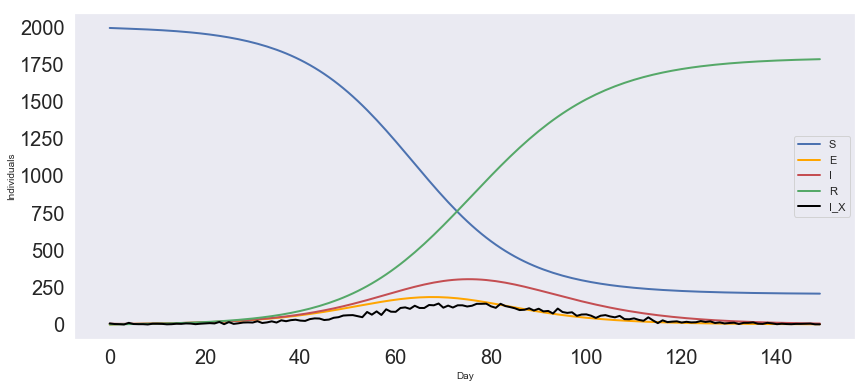

In [7]:
# concatenate vectors into matrix:
#Z = np.vstack((s, e,i, r)) * n_pop

# generate obserations:
p_obs     = 0.7
def sample_X(n_obs , I , p_obs):
    X = np.zeros(n_obs, dtype=int)
    for t in range(0, n_obs):
        X[t] =  np.random.negative_binomial(I[t], p_obs, size=1) 
    return X;

X         = sample_X(n_obs , Z[:,2] , p_obs)


seir.visualization(n_pop, X)

In [8]:
# unknown:
init_inf  = 5
t_inc     = 5
t_inf     = 9
r_t       = 2.5
rho       = 1.0


# known:
p_obs     = 0.7
kappa_0   = 0.0
kappa     = 0.0


# Put data in a dictionary
n_obs     = 150
n_theta   = 6
n_difeq   = 4
n_pop     = 2000
ts = np.arange(1,n_obs+1);

data = {'n_obs': n_obs, 'n_theta': n_theta, 'n_difeq': n_difeq, 'n_pop':n_pop, 'X': X, 't0': 0, 'ts': ts, 'kappa_0':kappa_0 ,'kappa':kappa, 'p_obs':0.7}


### Train the model with the data

In [9]:
# Train the model and generate samples
from tqdm import tqdm 
iter = 100000 # could be up to 100.000
chains = 4   # 4 
warmup = 500 # 500 
thin = 3 # take every 3rd sample from chain
fit = sm.sampling(data=data, iter=iter, chains=chains, warmup=warmup, thin=3, seed=101,verbose=True)

In [10]:
#learned statistics:
print(fit)

Inference for Stan model: anon_model_df4b9398b0a160ec9e0caf9fbcca0148.
4 chains, each with iter=100000; warmup=500; thin=3; 
post-warmup draws per chain=33167, total post-warmup draws=132668.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
t_inc         23.35     9.8  15.81   4.15   5.06  36.07  37.69  37.73      3   3.02
t_inf         22.71    1.55   4.68  18.01  19.51  21.28  25.59  37.01      9   1.54
r_t            9.31    3.91   6.43    0.9   2.49  10.98  16.96  17.34      3   3.17
rho            0.22    0.03    0.1   0.03   0.19    0.2   0.25   0.44     15   1.46
S0             0.74    0.17   0.27   0.33   0.36   0.82   0.99   0.99      2   3.35
Z_hat[1,1]   1484.6  346.59 540.42 653.07 724.12 1634.2 1970.6 1975.0      2   3.35
Z_hat[2,1]   1484.6  346.59 540.42 653.07 724.12 1634.2 1970.6 1975.0      2   3.35
Z_hat[3,1]   1484.6  346.59 540.42 653.07 724.12 1634.2 1970.6 1975.0      2   3.35
Z_hat[4,1]   1484.6  346.59 540.42 653.07 724.12 16

convergence, Rhat=1).


In [11]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

# Extracting traces
#p_obs_hat  = fit['p_obs']
t_inc_hat  = fit['t_inc']
t_inf_hat  = fit['t_inf']
r_t_hat    = fit['r_t']
rho_hat    = fit['rho']
lp         = fit['lp__']

In [22]:
# extract found Z mean values:
Z_hat = np.zeros((n_obs,n_difeq), dtype = int)
for i in range(0,4):
    for t in range(0,n_obs):
        index = 'Z_hat['+str(t+1)+','+str(i+1)+']'
        Z_hat[t,i]= int(df.loc[index,'mean'])

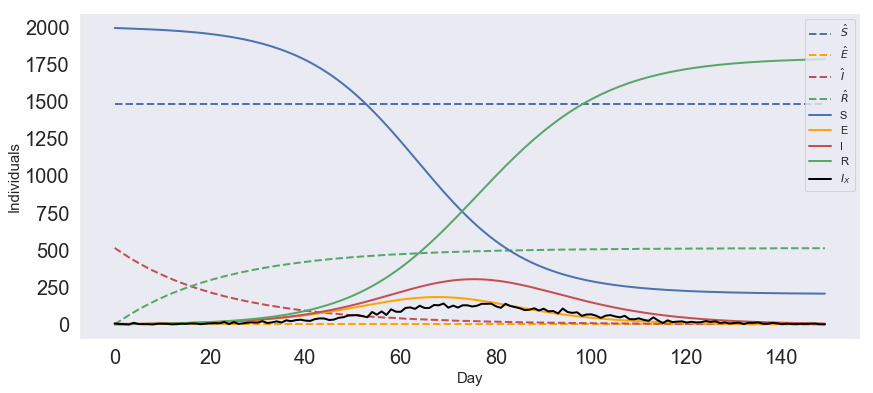

In [23]:
# Visualizing the process.
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(Z_hat[:,0], c='b', lw=2, label='$\hat{S}$', linestyle = '--')
ax.plot(Z_hat[:,1], c='orange', lw=2, label='$\hat{E}$', linestyle = '--')
ax.plot(Z_hat[:,2], c='r', lw=2, label='$\hat{I}$', linestyle = '--')
ax.plot(Z_hat[:,3], c='g', lw=2, label='$\hat{R}$', linestyle = '--')

ax.plot(Z[:,0], c='b', lw=2, label='S')
ax.plot(Z[:,1], c='orange', lw=2, label='E')
ax.plot(Z[:,2], c='r', lw=2, label='I')
ax.plot(Z[:,3], c='g', lw=2, label='R')

ax.plot(X, c='black', lw=2, label='$I_X$')

ax.set_xlabel('Day', fontsize=15)
ax.set_ylabel('Individuals', fontsize=15)
ax.grid()

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
plt.show()

In [14]:
df

mean      se_mean           sd          2.5%  \
t_inc            23.346120     9.795726    15.805188      4.147731   
t_inf            22.711611     1.547090     4.676723     18.009874   
r_t               9.308984     3.913067     6.426815      0.902542   
rho               0.215268     0.025360     0.099201      0.031206   
S0                0.742325     0.173294     0.270212      0.326534   
Z_hat[1,1]     1484.649570   346.588531   540.424321    653.067105   
Z_hat[2,1]     1484.649570   346.588531   540.424321    653.067105   
Z_hat[3,1]     1484.649570   346.588531   540.424321    653.067105   
Z_hat[4,1]     1484.649570   346.588531   540.424321    653.067105   
Z_hat[5,1]     1484.649570   346.588531   540.424321    653.067105   
Z_hat[6,1]     1484.649570   346.588531   540.424321    653.067105   
Z_hat[7,1]     1484.649570   346.588531   540.424321    653.067105   
Z_hat[8,1]     1484.649570   346.588531   540.424321    653.067105   
Z_hat[9,1]     1484.649570   346.588531   540.424321    653.067105   
Z_hat[10,1]    1484.649570   346.588531   540.424321    653.067105   
Z_hat[11,1]    1484.649570   346.588531   540.424321    653.067105   
Z_hat[12,1]    1484.649570   346.588531   540.424321    653.067105   
Z_hat[13,1]    1484.649570   346.588531   540.424321    653.067105   
Z_hat[14,1]    1484.649570   346.588531   540.424321    653.067105   
Z_hat[15,1]    1484.649570   346.588531   540.424321    653.067105   
Z_hat[16,1]    1484.649570   346.588531   540.424321    653.067105   
Z_hat[17,1]    1484.649570   346.588531   540.424321    653.067105   
Z_hat[18,1]    1484.649570   346.588531   540.424321    653.067105   
Z_hat[19,1]    1484.649570   346.588531   540.424321    653.067105   
Z_hat[20,1]    1484.649570   346.588531   540.424321    653.067105   
Z_hat[21,1]    1484.649570   346.588531   540.424321    653.067105   
Z_hat[22,1]    1484.649570   346.588531   540.424321    653.067105   
Z_hat[23,1]    1484.649570   346.588531   540.424321    653.067105   
Z_hat[24,1]    1484.649570   346.588531   540.424321    653.067105   
Z_hat[25,1]    1484.649570   346.588531   540.424321    653.067105   
...                    ...          ...          ...           ...   
Z_hat[132,4]    512.327554   346.770491   537.937164     24.923854   
Z_hat[133,4]    512.428858   346.778938   538.020637     24.924662   
Z_hat[134,4]    512.526564   346.786519   538.101081     24.925534   
Z_hat[135,4]    512.620807   346.793289   538.178616     24.926807   
Z_hat[136,4]    512.711719   346.799298   538.253354     24.927448   
Z_hat[137,4]    512.799423   346.804594   538.325405     24.928135   
Z_hat[138,4]    512.884040   346.809222   538.394873     24.928726   
Z_hat[139,4]    512.965684   346.813226   538.461857     24.929404   
Z_hat[140,4]    513.044467   346.816646   538.526454     24.929938   
Z_hat[141,4]    513.120495   346.819521   538.588755     24.930443   
Z_hat[142,4]    513.193869   346.821886   538.648849     24.930956   
Z_hat[143,4]    513.264688   346.823777   538.706820     24.931513   
Z_hat[144,4]    513.333046   346.825224   538.762750     24.932079   
Z_hat[145,4]    513.399034   346.826260   538.816714     24.932703   
Z_hat[146,4]    513.462739   346.826913   538.868790     24.933296   
Z_hat[147,4]    513.524244   346.827210   538.919047     24.933857   
Z_hat[148,4]    513.583631   346.827177   538.967555     24.934389   
Z_hat[149,4]    513.640976   346.826837   539.014379     24.934894   
Z_hat[150,4]    513.696354   346.826215   539.059582     24.935372   
Z_init[1]      1484.649570   346.588531   540.424321    653.067105   
Z_init[2]         0.000000          NaN     0.000000      0.000000   
Z_init[3]       515.350430   346.588531   540.424321     24.942897   
Z_init[4]         0.000000          NaN     0.000000      0.000000   
theta[1]         23.346120     9.795726    15.805188      4.147731   
theta[2]         22.711611     1.547090     4.676723     18.009874   
theta[3]          9.308984     3

In [15]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

C:\Users\henri\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


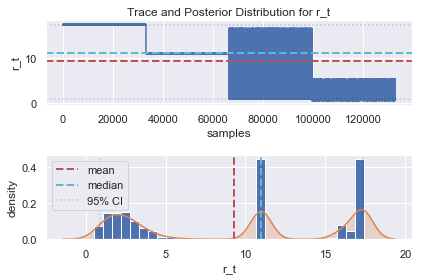

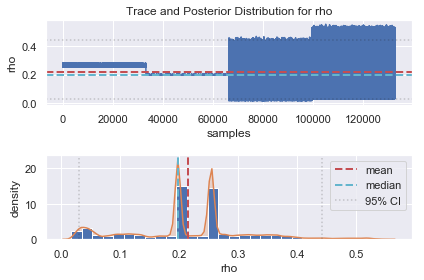

In [16]:
#plt.figure();
#plot_trace(p_obs_hat, param_name='p_obs')
plt.figure();
plot_trace(t_inc_hat, param_name='t_inc')
plt.figure();
plot_trace(r_t_hat, param_name='r_t')
plt.figure();
plot_trace(rho_hat, param_name='rho')


### Very simple older model:

In [ ]:
def sample_Z( T, p_inf, N, Z_0= 1):
    Z = np.zeros(T,dtype=int)
    Z[0] = Z_0;
    for t in range(1, T):
        Z[t] =  Z[t - 1]+np.random.binomial(N-Z[t-1], p_inf, 1) # one try    
    return Z;

def sample_X(T,Z, p_obs):
    X = np.zeros(T,dtype=int)
    for t in range(0, T):
        X[t] =  Z[t] +np.random.negative_binomial(Z[t], p_obs, size=1) 
    return X;

In [ ]:
# Parameters to be inferred
p_inf   = 0.001
p_obs   = 0.7

# sample from a data generator
Z = sample_Z( T, p_inf, N, Z_0= 10)
X = sample_X( T, Z, p_obs)
print(Z)
print(X)

In [ ]:
plt.plot(Z, color ="red")
plt.plot(X)

In [ ]:
# Put our data in a dictionary
data = {'N': N, 'T': T, 'X': X, 'Z':Z}

In [ ]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

In [ ]:
print(fit)

In [ ]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

alpha_mean, beta_mean = df['mean']['p_inf'], df['mean']['p_obs']

# Extracting traces
p_inf_f = fit['p_inf']
p_obs_f = fit['p_obs']
lp = fit['lp__']

In [ ]:
plot_trace(p_obs_f, param_name='parameter')